In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers




Using TensorFlow backend.


In [3]:
# Load the clean dataset
UNSW_NB15_dataset = pd.read_csv('UNSW_NB15_dataset.csv',index_col=0)
UNSW_NB15_dataset.head()




/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,1390.0,53.0,0.001055,132,164,31,29,0,0,500473.93750,...,0,0,0,0,0,0,0,0,0,0
1,33661.0,1024.0,0.036133,528,304,31,29,0,0,87676.08594,...,0,0,0,0,0,0,0,0,0,0
2,1464.0,53.0,0.001119,146,178,31,29,0,0,521894.53130,...,0,0,0,0,0,0,0,0,0,0
3,3593.0,53.0,0.001209,132,164,31,29,0,0,436724.56250,...,0,0,0,0,0,0,0,0,0,0
4,49664.0,53.0,0.001169,146,178,31,29,0,0,499572.25000,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Select sbytes, sttl, smeansz, ct_dst_sport_ltm, and label columns
unsw_data = UNSW_NB15_dataset.loc[:,['sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'Label']]
unsw_data.head()


,sbytes,sttl,smeansz,ct_dst_sport_ltm,Label
0,132,31,66,1,0
1,528,31,132,1,0
2,146,31,73,1,0
3,132,31,66,1,0
4,146,31,73,1,0


In [7]:
from sklearn.model_selection import train_test_split

# Train, validation, test : 98%, 1%, 1% of dataset
X_train, X = train_test_split(unsw_data, test_size = 0.02, random_state = 101)

# We need to train our model on the normal observations only.
X_train = X_train[X_train.Label == 0] # just normal observations
X_train = X_train.drop(['Label'], axis=1) # drop the Label column

y = X['Label'] # save the Label column for the validation and test sets
X = X.drop(['Label'], axis=1) # drop the Label column

# Create the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state = 101)

#transform to ndarray
X_train = X_train.values 
X_val = X_val.values
X_test = X_test.values



In [8]:
print ('train size:', X_train.shape)
print ('validation size:', X_val.shape)
print ('test size:', X_test.shape)


train size: (2174059, 4)
validation size: (25397, 4)
test size: (25398, 4)


In [9]:
from sklearn.preprocessing import StandardScaler

st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)
X_val = st_sc.transform(X_val)
X_test = st_sc.transform(X_test)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='relu')(decoded)

autoencoder = Model(input_layer, decoded)


In [11]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
Total para

The idea behind using autoencoders to detect anomalies is to train the model on just normal observations. By this, we mean that we train the autoencoder on the unlabled dataset containing only normal observations, and then predict the test set which contains both normal and attack observations. We expect that the model which is trained on normal observations recreate the normal observations in the test set more accurately and produce attack observations in the test set with higher error.

In [13]:
import datetime

autoencoder.compile(optimizer='adam',
                    loss='mse') 

checkpointer = ModelCheckpoint(filepath="anomaly_autoencoders_model_v2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(write_graph=True,
                          write_images=True)

start_time = datetime.datetime.now()

history = autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=0,
                    callbacks=[checkpointer, tensorboard])

end_time = datetime.datetime.now()

print('Time taken to run the model: {} Sec.'.format((end_time - start_time).total_seconds()))



Time taken to run the model: 3815.689188 Sec.


In [14]:
history_dict = history.history



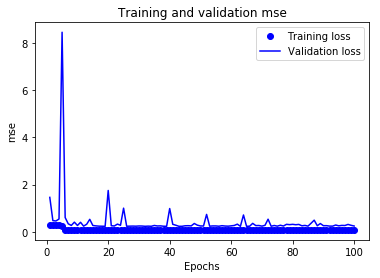

In [16]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = np.arange(1, 100 + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()
plt.show()



In [17]:
autoencoder = load_model('anomaly_autoencoders_model_v2.h5')


In [18]:
predictions = autoencoder.predict(X_test)


As we mentioned before, we need a metric to calculate the difference between the original input and the recreated one. Here we use root mean squared difference between the prediction and the original observations to be able to distinguish between normal and attack observations according to the magnitude of the calculated error.

In [19]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
rmse = pow(mse,0.5)
error_df = pd.DataFrame({'reconstruction_error': rmse,
                        'true_class': y_test})
error_df.describe()


,reconstruction_error,true_class
count,25398.000000,25398.000000
mean,0.351507,0.127175
std,0.324074,0.333176
min,0.065754,0.000000
25%,0.223574,0.000000
50%,0.294757,0.000000
75%,0.322927,0.000000
max,4.398616,1.000000


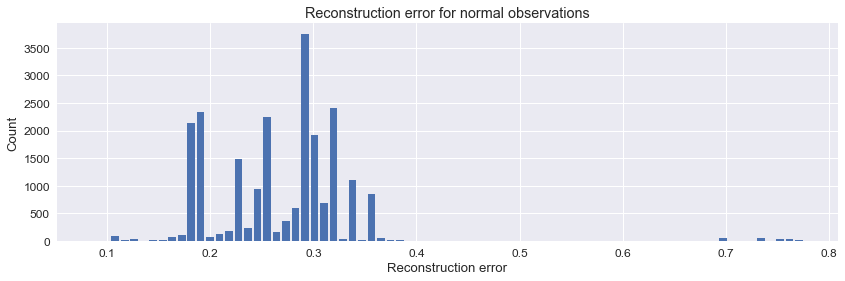

In [20]:
sns.set(font_scale=1.2)
normal_data = error_df[(error_df['true_class']== 0)].reconstruction_error
normal_data.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('Reconstruction error for normal observations')
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.show()



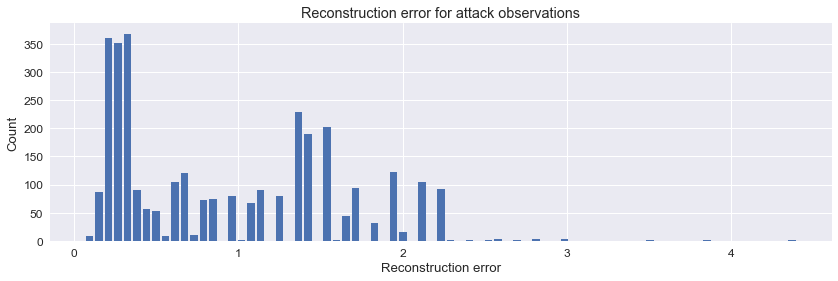

In [21]:
sns.set(font_scale=1.2)
attack_data = error_df[(error_df['true_class']== 1)].reconstruction_error
attack_data.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('Reconstruction error for attack observations')
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.show()


After calculating the reconstruction error which is the difference between the original and predicted observations, we need to define a threshold to see the outliers. In other words, the treshold is the line that separate normal points from attack ones.

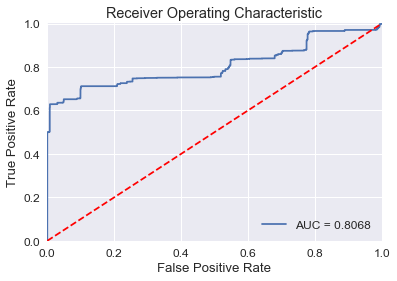

In [22]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


As you know we are dealing with an unbalanced dataset and it is better to take recall and precision into account as the criteria for calculating the accuracy of our model. Here the positive class is the attack and negative class belongs to normal observations. The goal is to recognize positive class more accurately. So, we are more eager to avoid false negatives rather than false positives. In other words, predicting some actual normal observations as attack class is not as bad as predicting some  attack observations as normal ones. As a result, having a higher recall would be more important than having a high precision. We need to look for a threshold to give us a high recall but also not very low precision.

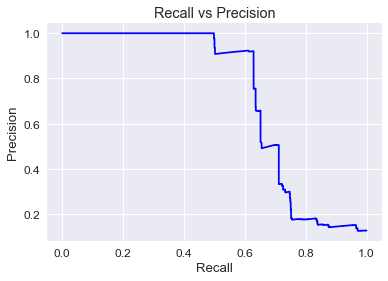

In [23]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


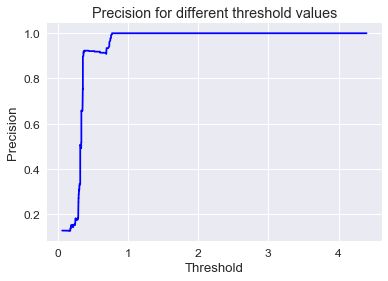

In [24]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()


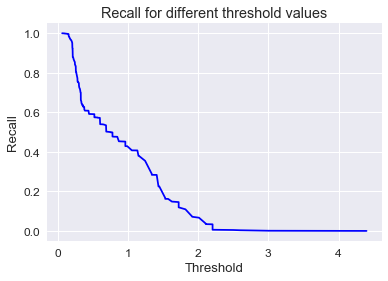

In [25]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()


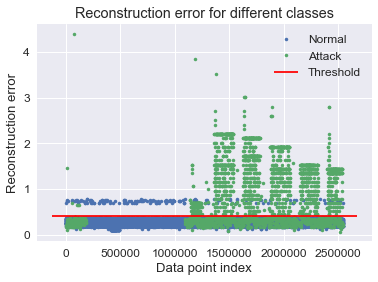

In [33]:
threshold = .4
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


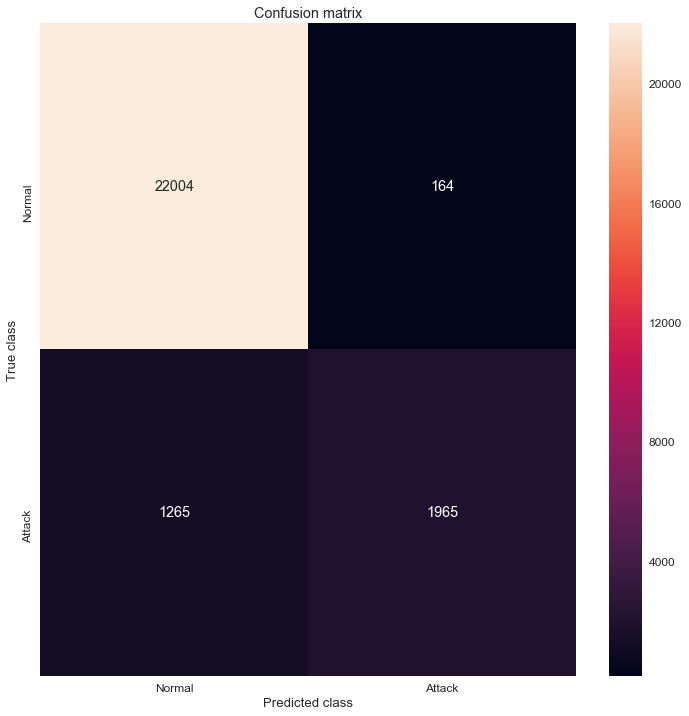

In [34]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Attack"], 
            yticklabels=["Normal", "Attack"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


We can see the effect of different features on the reconstruction arror. By computing the difference between the original and predicted observations in the test set for each feature we can find out which features have the significant effect on the reconstruction error.

In [59]:
# List of outliers
threshold = 0.4
outliers_index = error_df.index[error_df.reconstruction_error > threshold].tolist()



In [60]:
# Number of outliers
len(outliers_index)


2129

In [61]:
# Let's compute reconstruction error per feature

cols = ['sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm']
data_n = pd.DataFrame(X_test, index= y_test.index, columns= cols)
def compute_error_per_feature(index):
    
    initial_input = np.array(data_n.loc[index,:]).reshape(1, input_dim)
    reconstrcuted_input = autoencoder.predict(initial_input)
    
    return abs(np.array(initial_input  - reconstrcuted_input)[0])




In [62]:

RE_per_feature = {}
for idx in outliers_index:
    RE_per_feature[idx] = compute_error_per_feature(idx)
    
RE_per_feature = pd.DataFrame(RE_per_feature, index= cols).T



In [63]:
RE_per_feature.head()


,sbytes,sttl,smeansz,ct_dst_sport_ltm
2435538,0.375336,0.034274,0.471608,2.809431
1706563,0.375336,0.034274,0.471608,2.809431
1637403,0.375336,0.806005,0.471608,5.932803
1167421,0.375336,0.011169,0.471608,1.247745
2306456,0.375336,0.006633,0.471608,2.028588


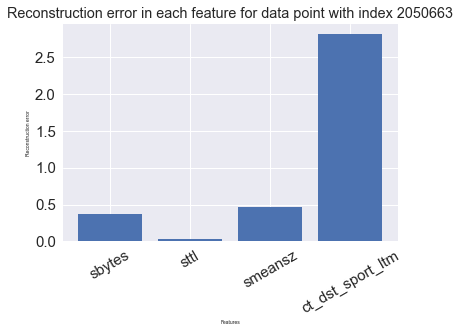

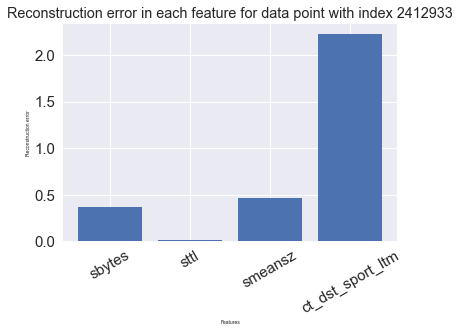

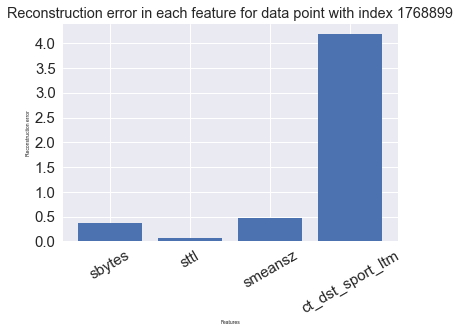

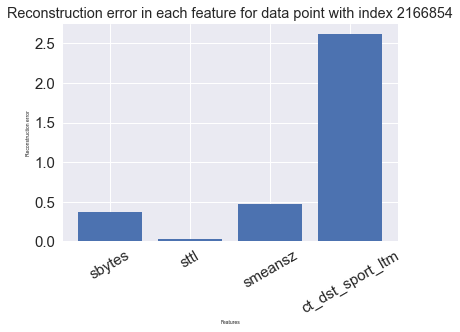

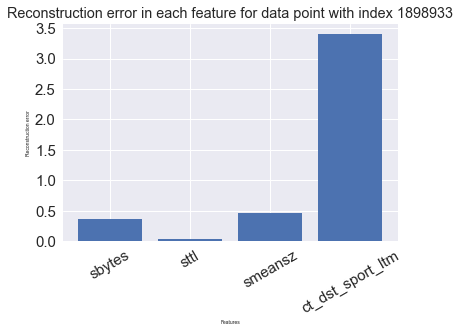

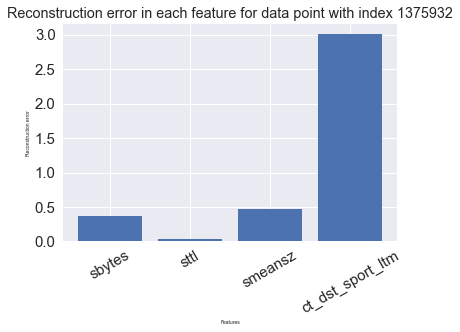

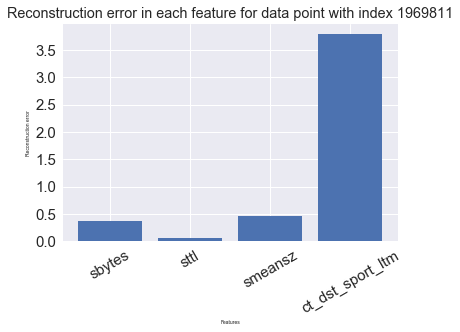

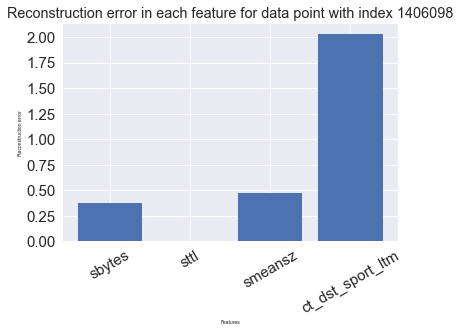

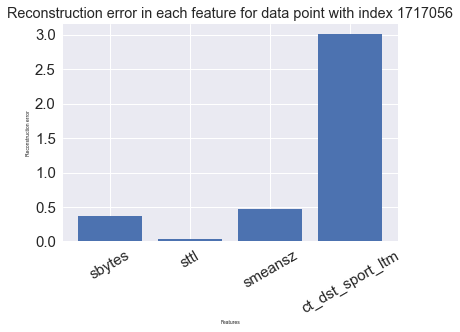

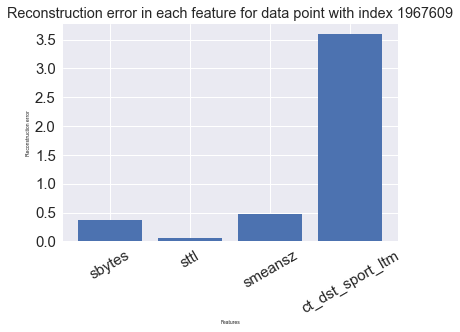

In [58]:
# Create bar plot of "RE_per_feature"

import random

sns.set(font_scale=1.2)
# Select 10 random index from outliers_index and
# create the bar plot of reconstruction error for features
for idx in random.sample(outliers_index, 10):
    
    x = RE_per_feature.columns.tolist()
    y = RE_per_feature.loc[idx]
    index = np.arange(len(x))
    plt.bar(x, y)
    plt.xlabel('Features', fontsize=5)
    plt.ylabel('Reconstruction error', fontsize=5)
    plt.xticks(index, x, rotation=30, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Reconstruction error in each feature for data point with index %s'%idx)
    plt.show()
    



We picked then outliers randomly and calculated the reconstruction error of their features. the result shows that the 'ct_dst_sport_ltm' has the highest effect on the reconstruction arror. Apparently the 'sttl' also has the lowest impact on the reconstruction error.